<a href="https://colab.research.google.com/github/danielfrgs/2022_1-Datos-Masivos-I/blob/main/Proyectos/P2/Proyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Proyecto 2: Búsqueda de pares similares

Fragoso Alvarado Daniel

Gómez Martínez Jesús Enrique

Rangel Ramirez Hugo


---

La base de datos fue obtenida de la discusión de [Kaggle](https://www.kaggle.com/datasets/zynicide/wine-reviews); el cual consiste de 3 archivos:

- `winemag-data-130k-v2.csv` contiene 10 columnas y 130 000 filas de reseñas de vinos.

- `winemag-data_first150k.csv` contiene 10 columnas y 150 000 filas de reseñas de vinos.

- `winemag-data-130k-v2.json` contiene 6919 nodos de reseñas de vinos.

Vamos a usar el segundo de estos archivos: `winemag-data_first150k.csv`  por ser el que más regsitros contiene.

In [ ]:
# Importamos las librerias

from collections import  Counter
import re
import codecs
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'


VOCMAX = 5000

In [ ]:
# Leemos los datos
df = pd.read_csv('winemag-data_first150k.csv')
db = np.array(df['description'])

In [ ]:
# Observamos una de estas reseñas
print(db[1])

Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.


In [ ]:
# Vamos aimportar la libreria nltk con el fin de 
# lematizar nuestros datos

import nltk
nltk.download(['punkt','averaged_perceptron_tagger','wordnet'])

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ

morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}

#Definimos nuestra función que tokenizara y lematizara nuestros datos
def doc_a_tokens(doc):
  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))

  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#Preparación de los datos

In [ ]:
#Para todo el texto quitamos espacios y tabuladores, y homogeneizamos el texto
corpus = []
for d in db:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  d = ' '.join([''.join([c.lower() for c in p if c.isalnum()]) for p in d.split()])
  tokens = doc_a_tokens(d)
  corpus.append(' '.join(tokens))

In [ ]:
#Quitamos las Stopwords mas complejos
!wget -qO- -O stopwords_english.txt \
         https://raw.githubusercontent.com/pan-webis-de/authorid/master/data/stopwords_english.txt

stopwords = []
for line in codecs.open('stopwords_english.txt', encoding = "utf-8"):
  stopwords.append(line.rstrip())

In [ ]:
# Divide la cadena en palabras
term_re = re.compile("\w+", re.UNICODE)

# Contamos las ocurrencias de cada palabra
corpus_freq = Counter()
doc_freq = Counter()
for d in corpus:
  # Eliminamos números de la cadena (documento) a procesar 
  d = re.sub(r'\d+', '', d)

  # Dividimos la cadena en una lista de palabras
  terms = [t for t in term_re.findall(d) if t not in stopwords and len(t) > 2]
  
  # Aumentamos el contador de cada instancia palabra en el documento
  for t in terms:
    corpus_freq[t] += 1
  
  # Aumentamos el contador de cada palabra distinta en el documento
  for t in set(terms):
    doc_freq[t] += 1

# Generamos un diccionario con las VOCMAX palabras más frecuentes
vocabulary = {entry[0]:(i, entry[1], doc_freq[entry[0]], log(len(corpus) / doc_freq[entry[0]])) \
              for i, entry in enumerate(corpus_freq.most_common()) \
              if i < VOCMAX}

## Exploración de los Datos

Vamos a generar una exploración del conjunto de datos para observar su conportamiento y recabar algo de contexto e información a partir de las siguientes preguntas:

### ¿Qué palabra se repite más?

In [ ]:
sort = sorted(corpus_freq.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Seleccionamos solo las primeras 50 palabras más repetidas
size = [x[1] for x in sort][:50]
word = [x[0] for x in sort][:50]

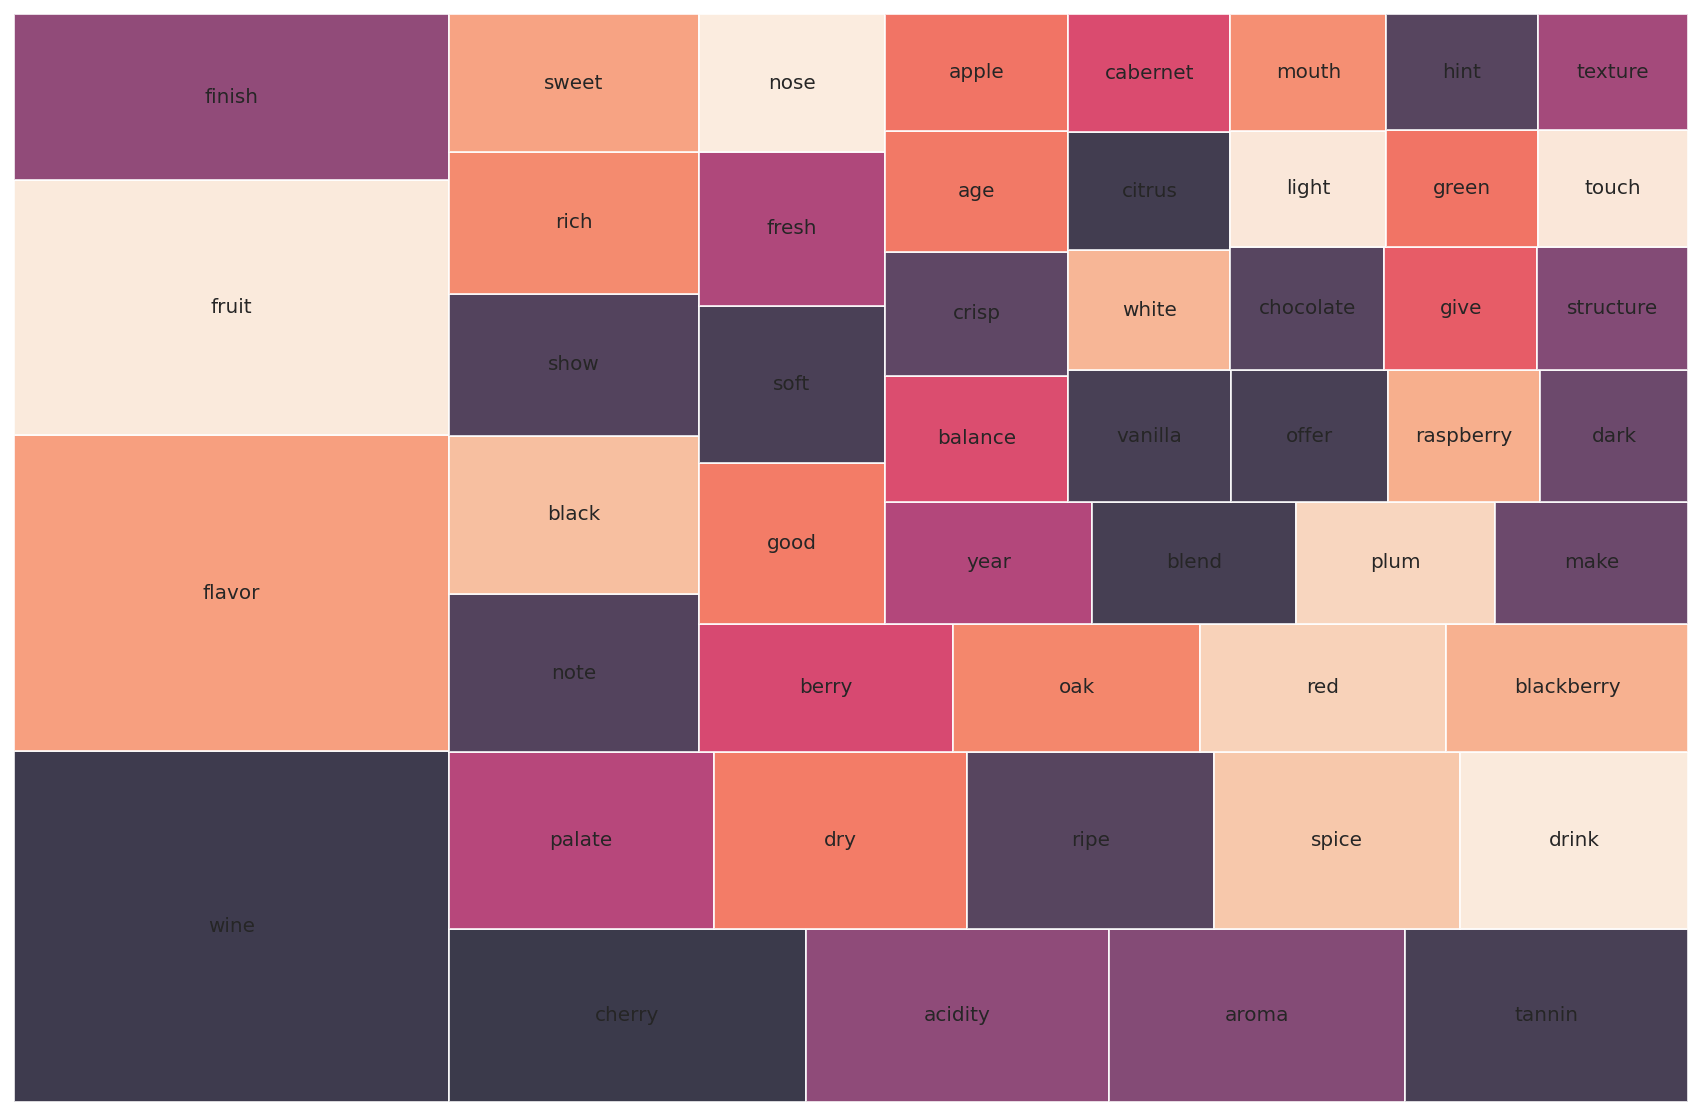

In [ ]:
# Importamos las librerias para hacer un mapa de arbol
! pip install squarify
import squarify
import pandas as pd

# Creamos un dataframe auxiliar
df = pd.DataFrame({'Repeticiones': size, 'Palabra':word})
plt.rcParams["figure.figsize"] = (15,10)
# plot it
squarify.plot(sizes=df['Repeticiones'], label=df['Palabra'], alpha=.8 )
plt.axis('off')
plt.show()

Notemos que la mayoria de las plaabras de mayor repetición son caracteristicas que suelen acompañar a un vino, 'frutal', 'seco', 'fresco', 'liger', 'tinyo, etc. Lo cual nos indica que las reseñas son mayormente sobre caracteristicas propias del vino.

### ¿Cuantas palabras tienen las reseñas?

In [ ]:
# Contamos sobre cada una de las reseñas

long_p = [len(x) for x in db]

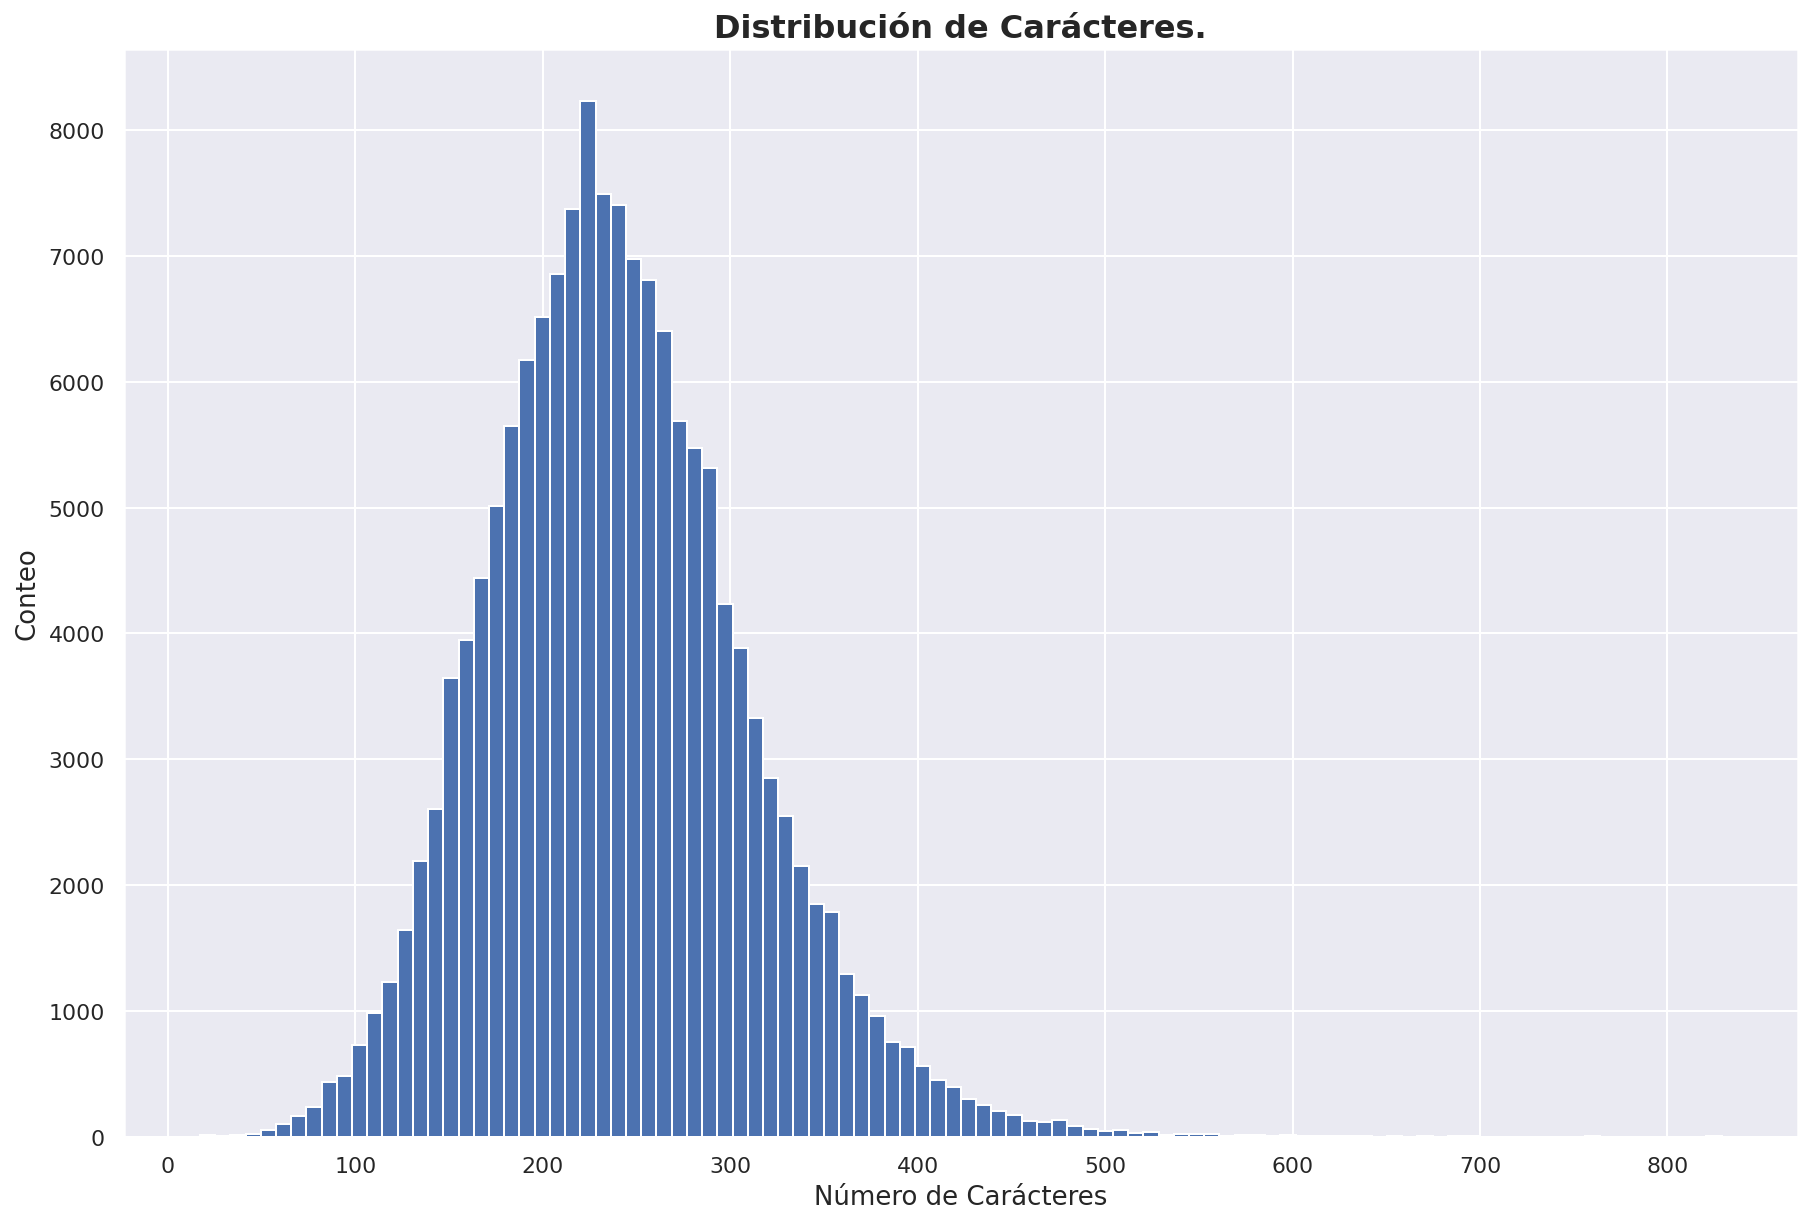

In [ ]:
#   Generamos un histograma
plt.hist(long_p, bins = 100)
plt.xlabel('Número de Carácteres', size = 13)
plt.ylabel('Conteo', size = 13)
  
plt.title('Distribución de Carácteres.',
          fontweight ="bold", size = 16)
plt.show()

Observemos que la mayoria de las reseñas se concentran al rededor de los 200 carácteres. Lo cual es una buena longitud para reseñas de internet.

### Análisis de sentimientos

¿Cuan positivas o negativas son las reseñas?

In [ ]:
#Instalación de bibliotecas adicionales
# Procesamiento del lenguaje natural
!pip install pyspark
!pip install nltk
!pip install --upgrade pip
!python -m nltk.downloader all

!pip install sentiment-analysis-spanish
!pip install keras tensorflow

In [ ]:
#Carga de bibliotecas
import pyspark
from pyspark.sql.functions import * 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MapReduce').getOrCreate()

#Carga de bibliotecas extras
import numpy as np
import matplotlib.pyplot as plt

#Carga de NLTK
import nltk
import string
from sentiment_analysis_spanish import sentiment_analysis

In [ ]:
# Geeneramos el rdd de la lectura de los datos
rdd = spark.sparkContext.textFile('winemag-data_first150k.csv').map(lambda x: x.split(','))
rdd = rdd.map(lambda x: x[2])

for opinion in rdd.take(5):
  print(opinion)

description
"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate
"Ripe aromas of fig
"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious
"This spent 20 months in 30% new French oak


In [ ]:
rdd_palabras = rdd.map(lambda x: (x.split(' ')))

for letra in rdd_palabras.take(5):
  print(letra)

['description']
['"This', 'tremendous', '100%', 'varietal', 'wine', 'hails', 'from', 'Oakville', 'and', 'was', 'aged', 'over', 'three', 'years', 'in', 'oak.', 'Juicy', 'red-cherry', 'fruit', 'and', 'a', 'compelling', 'hint', 'of', 'caramel', 'greet', 'the', 'palate']
['"Ripe', 'aromas', 'of', 'fig']
['"Mac', 'Watson', 'honors', 'the', 'memory', 'of', 'a', 'wine', 'once', 'made', 'by', 'his', 'mother', 'in', 'this', 'tremendously', 'delicious']
['"This', 'spent', '20', 'months', 'in', '30%', 'new', 'French', 'oak']


In [ ]:
#Removemos stopwords 
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

rdd_stop = rdd_palabras.map(removeStopWordsFunct)

for palabra in rdd_stop.take(2):
  print(palabra)

['description']
['"This', 'tremendous', '100%', 'varietal', 'wine', 'hails', 'Oakville', 'aged', 'three', 'years', 'oak.', 'Juicy', 'red-cherry', 'fruit', 'compelling', 'hint', 'caramel', 'greet', 'palate']


In [ ]:
#Eliminamos signos de puntuación y espacios en blanco
import string
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

rdd_punct = rdd_stop.map(removePunctuationsFunct)

for palabra in rdd_punct.take(2):
  print(palabra)

['description']
['This', 'tremendous', '100', 'varietal', 'wine', 'hails', 'Oakville', 'aged', 'three', 'years', 'oak', 'Juicy', 'redcherry', 'fruit', 'compelling', 'hint', 'caramel', 'greet', 'palate']


In [ ]:
#Análisis de sentimientos a partir de las función definida en clase 
def sentimentWordsFunct(x):
  from nltk.sentiment.vader import SentimentIntensityAnalyzer
  analyzer = SentimentIntensityAnalyzer() 
  senti_list_temp = []
  for i in x:
    y = ''.join(i) 
    vs = analyzer.polarity_scores(y)
    senti_list_temp.append((y, vs))
    senti_list_temp = [w for w in senti_list_temp if w]
  sentiment_list  = []
  for j in senti_list_temp:
    first = j[0]
    second = j[1]
    
    for (k,v) in second.items():
      if k == 'compound':
        if v < 0.0:
          sentiment_list.append((first, "Negative"))
        elif v == 0.0:
          sentiment_list.append((first, "Neutral"))
        else:
          sentiment_list.append((first, "Positive"))
  return sentiment_list

sentimentRDD = rdd_punct.map(sentimentWordsFunct)

In [ ]:
# Mapeamos sobre cada reseña 
sent = sentimentRDD.map(lambda x: [y[1] for y in x])

In [ ]:
# Generamos una función que resuma todas las palabras de una reseña en solo uno 
# de las tres categorias
def posorneg(lista):
  # Contamos cuatos valores hay de cada uno 
  vals = pd.Index(lista).value_counts()
  # Si hay neutrales las eleiminamos
  if 'Neutral' in vals:
    vals = vals.drop('Neutral')
  # Convertimos a lista el. nuevo conjunto
  result = list(vals[vals == vals.max()].index)
  # Si no hay nada en la lista, no es ni positivo ni negativo, asignamos neutral
  if len(result) == 0:
    return('Neutral')
  # Si hay misma cantidad de positivos y negativos es neutral
  if len(result) == 2:
    return('Neutral')
  # Sino regresamos la categoria de mayor repetición
  else:
    return(result[0])

In [ ]:
# Mapeamos
res = sent.map(lambda x: posorneg(x))

In [ ]:
# Seleccionamos las primeras 100, 000 reseñas por cuestiones de tiempo
cant = pd.Index(list(res.take(100000))).value_counts()
cant

Neutral     57312
Positive    39032
Negative     3656
dtype: int64

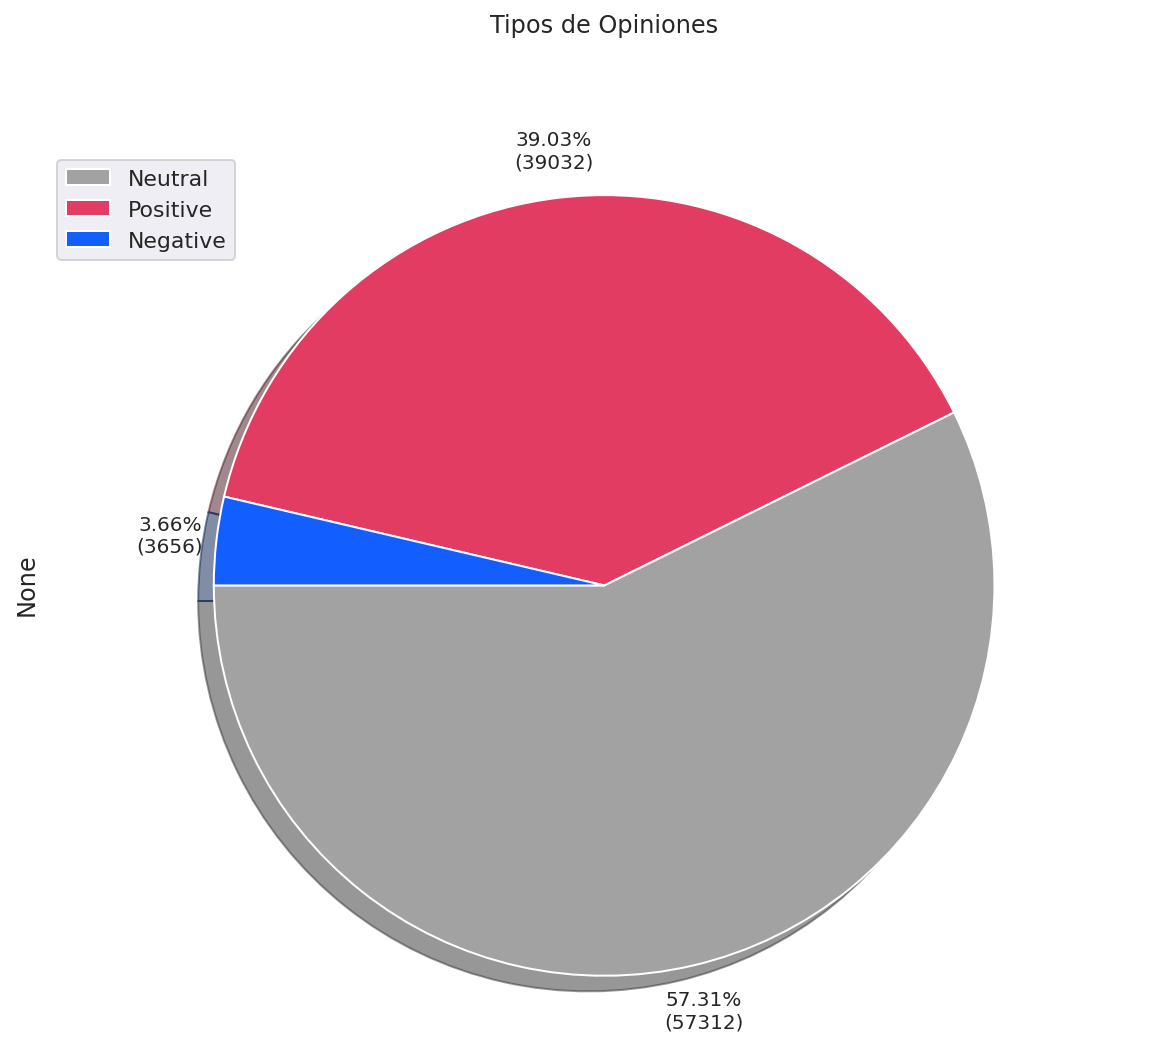

In [ ]:
# Generamos una gráfica de barras
def my_fmt(x):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

total = cant.sum()

colors_list = ['#A2A2A2', '#E33C62', '#125EFF', '#2C2358', '#FFC918', '#C1DD46']

cant.plot(kind='pie',
          figsize=(10, 8),
          autopct=my_fmt, 
          startangle=180,    
          shadow=True,       
          labels=None,         # desactive las etiquetas en el gráfico circular
          pctdistance=1.12,    # la relación entre el centro de cada sector circular y el inicio del texto generado por autopct
          colors=colors_list,  # añadir colores personalizados
          subplots=True)

# aumentar el título en un 12% para que coincida con pctdistance
plt.title('Tipos de Opiniones', y=1.12) 

plt.axis('equal') 

# añadir leyenda
plt.legend(labels=cant.index, loc='upper left') 

plt.show()

Dado lo relativo que puede ser categorizar un bino en términos de bueno o malo, asumimos que la mayoria de las reseñas son simplemente sobre las caracteristicas, y si en segundo lugar, por alguna recomendación personal, agregar comentarios positivos del vino, pero por otro lado, se tienen pcas reseñas negativas, esto puede deberse a que que no le haya gustado a ti significa forzozamente que sea un mal vino.

## Análisis de Similitud

Tras una revisión rápida, vamos a generar nuestras bolsas para hacer el análisis de similitud.

In [ ]:
#Creamos un diccionario para mapear índices a palabras
id_a_palabra = {v[0]: k for k,v in vocabulary.items()}

In [ ]:
#Generamos las bolsas de palabras de los documentos preprocesados
bolsas = []
for d in corpus:
  d = re.sub(r'\d+', '', d)
  ids = Counter([vocabulary[t][0] for t in term_re.findall(d) \
                 if t in vocabulary and t not in stopwords])
  bolsas.append([i for i in sorted(ids.items())])

#Indice Invertido

En un índice invertido, el buscador crea los índices, o términos de búsqueda, a partir de una serie de documentos, indicando el o los documentos que los contienen.

De esta manera, cuando el usuario teclea un término de búsqueda determinado, el buscador le indica los documentos que contienen dicho término.

In [ ]:
#Definimos la clase para el índice inverso con un método para recuperar los documentos que contienen una lista de palabras
class IndiceInverso:
  #permite que sus instancias usen los operadores
  def  __getitem__(self, idx):
    return self.ifs[idx]
  #representar los objetos de una clase como una cadena
  def __repr__(self):
    contenido = ['%d::%s' % (i, self.ifs[i]) for i in range(len(self.ifs))]
    return "<IFS :%s >" % ('\n'.join(contenido))

  def __str__(self):
    contenido = ['%d::%s' % (i, self.ifs[i]) for i in range(len(self.ifs))]
    return '\n'.join(contenido)

  def recupera(self, l):
    return Counter([j for (i,_) in l for j in self.ifs[i]])

  def construye(self, bd, tvoc):
    self.ifs = [[] for _ in range(tvoc)]

    for i,d in enumerate(bd):
      for p in d:
        self.ifs[p[0]].append(i)

In [ ]:
#Instanciamos nuestra clase IndiceInverso y creamos la estructura a partir de nuestras bolsas de palabras
ifs = IndiceInverso()
ifs.construye(bolsas, VOCMAX)

#Ejemplo

In [ ]:
#Generamos nuestras consultas y calculamos las bolsas
consultas = ['delicate honey tone', 'subtle aromas of black-skin fruit']
bolsas_consultas = []
for c in consultas:
  c = re.sub(r'\d+', '', c)
  ids = Counter([vocabulary[t][0] for t in term_re.findall(c) \
                 if t not in stopwords and vocabulary[t][0] < VOCMAX])            
  bolsas_consultas.append([i for i in sorted(ids.items())])

In [ ]:
#Recuperamos el documento y mostramos de la forma (documento, conteo de apariciones)
recs = ifs.recupera(bolsas_consultas[0])
top = recs.most_common()[0]
print(recs.most_common())
print(db[top[0]])

[(14684, 3), (25610, 3), (31313, 3), (31637, 3), (54997, 3), (63006, 3), (65944, 3), (73940, 3), (75187, 3), (102161, 3), (103446, 3), (108764, 3), (111934, 3), (124994, 3), (134914, 3), (146676, 3), (636, 2), (1573, 2), (1801, 2), (2119, 2), (2310, 2), (2501, 2), (3110, 2), (3180, 2), (3188, 2), (3268, 2), (3277, 2), (3396, 2), (3399, 2), (3416, 2), (3512, 2), (3720, 2), (4594, 2), (4654, 2), (5152, 2), (5368, 2), (5651, 2), (6302, 2), (6838, 2), (7079, 2), (7081, 2), (7319, 2), (7352, 2), (7591, 2), (7737, 2), (8019, 2), (8771, 2), (9637, 2), (10009, 2), (10461, 2), (10480, 2), (10611, 2), (10778, 2), (10883, 2), (11072, 2), (11282, 2), (11379, 2), (11390, 2), (11719, 2), (11786, 2), (11894, 2), (12078, 2), (12079, 2), (12318, 2), (12438, 2), (12625, 2), (12693, 2), (12908, 2), (14514, 2), (14721, 2), (14948, 2), (15506, 2), (15767, 2), (16201, 2), (16612, 2), (16806, 2), (17515, 2), (18352, 2), (19570, 2), (20766, 2), (21421, 2), (22068, 2), (22239, 2), (22253, 2), (22358, 2), (2268

In [ ]:
#Ahora para la segunda consulta
recs = ifs.recupera(bolsas_consultas[1])
top = recs.most_common()[0]
print(recs.most_common())
print(db[top[0]])

[(12890, 4), (13122, 4), (44597, 4), (78974, 4), (93880, 4), (99497, 4), (141520, 4), (3, 3), (64, 3), (79, 3), (144, 3), (319, 3), (435, 3), (449, 3), (666, 3), (707, 3), (892, 3), (1214, 3), (1452, 3), (1527, 3), (1687, 3), (2056, 3), (2186, 3), (2288, 3), (2309, 3), (2454, 3), (2473, 3), (2498, 3), (2560, 3), (2592, 3), (2643, 3), (2697, 3), (2757, 3), (2837, 3), (2863, 3), (2874, 3), (3026, 3), (3501, 3), (3556, 3), (3586, 3), (3628, 3), (3640, 3), (3671, 3), (3930, 3), (3960, 3), (4081, 3), (4108, 3), (4233, 3), (4299, 3), (4427, 3), (4455, 3), (4472, 3), (4487, 3), (4649, 3), (5038, 3), (5192, 3), (5233, 3), (5325, 3), (5411, 3), (5534, 3), (5675, 3), (5745, 3), (5795, 3), (5896, 3), (6025, 3), (6202, 3), (6383, 3), (6389, 3), (6404, 3), (7431, 3), (7523, 3), (7621, 3), (7696, 3), (7858, 3), (8000, 3), (8077, 3), (8306, 3), (8345, 3), (8984, 3), (9252, 3), (9609, 3), (9667, 3), (9878, 3), (9933, 3), (10026, 3), (10240, 3), (10490, 3), (10519, 3), (10528, 3), (10727, 3), (10809, 3

#Documentos similares

A continuación realizaremos la búsqueda de documentos similares respecto a el documento muestra, en este caso nos tomamos el primero de la lista.

In [ ]:
#Documento muestra
dc = 0 
print(db[dc])

This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.


Obtenemos su bolsa

In [ ]:
bolsa_dc = bolsas[dc]

Definimos una función para hacer búsqueda por fuerza bruta dada una función de distancia o similitud

In [ ]:
def fuerza_bruta(base, consulta, fd):
  medidas = np.zeros(len(base))
  for i,x in enumerate(base):
    medidas[i] = fd(consulta, x)

  return medidas

Definimos la función para la similitud coseno

In [ ]:
def similitud_coseno(x, y):
  ax = np.zeros(VOCMAX)
  for e in x:
    ax[e[0]] = e[1] * vocabulary[id_a_palabra[e[0]]][-1]

  ay = np.zeros(VOCMAX)
  for e in y:
    ay[e[0]] = e[1] * vocabulary[id_a_palabra[e[0]]][-1]

  pnorma = (np.sqrt(ax @ ax) * np.sqrt(ay @ ay))

  if pnorma > 0:
    return (ax @ ay) / pnorma
  else: 
    return np.nan 

In [ ]:
#Calculamos la similitud máxima con la similitud coseno
bolsas_base = [b for i,b in enumerate(bolsas) if i != dc]
sims = fuerza_bruta(bolsas_base, bolsa_dc, similitud_coseno)

In [ ]:
#Recordemos que estamos comparando con el documento muestra dc=0 mostrado anteriormente
print('Similitud máxima es {0} de documento {1}'.format(np.nanmax(sims), np.nanargmax(sims)+ 1))

Similitud máxima es 0.2698466916905433 de documento 23039


Revisamos documento más similar

In [ ]:
print(db[np.nanargmax(sims) + 1])

A dry wine with firm tannins over the juicy red-cherry fruits. It is structured, while likely to develop well over the next few years. The wood and fruit are both attractive at this stage.


Hacemos lo mismo para la similitud de Jaccard y MinMax

In [ ]:
def similitud_jaccard(x, y):
  ax = np.zeros(VOCMAX)
  for e in x:
    ax[e[0]] = 1

  ay = np.zeros(VOCMAX)
  for e in y:
    ay[e[0]] = 1

  inter = np.count_nonzero(ax * ay)
  return inter / (np.count_nonzero(ax) + np.count_nonzero(ay) - inter)

def similitud_minmax(x, y):
  ax = np.zeros(VOCMAX)
  for e in x:
    ax[e[0]] = e[1]

  ay = np.zeros(VOCMAX)
  for e in y:
    ay[e[0]] = e[1]

  c = np.vstack((ax,ay))
  mn = np.sum(np.min(c, axis=0))
  mx = np.sum(np.max(c, axis=0))
  return mn / mx

Calculamos las similitudes con todos los documentos

In [ ]:
js = fuerza_bruta(bolsas_base, bolsa_dc, similitud_jaccard)
mms = fuerza_bruta(bolsas_base, bolsa_dc, similitud_minmax)
print('Similitud de Jaccard máxima es {0} de documento {1}'.format(np.nanmax(js), np.nanargmax(js) + 1))
print('Similitud de MinMax máxima es {0} de documento {1}'.format(np.nanmax(mms), np.nanargmax(mms) + 1))

Similitud de Jaccard máxima es 0.20408163265306123 de documento 65659
Similitud de MinMax máxima es 0.1956521739130435 de documento 145768


Visualizamos documento con mayor similitud de Jaccard

In [ ]:
print(db[np.nanargmax(js) + 1])

An elegant style, the ripe fruit restrained and kept in check by the dry tannins and acidity. The flavors start lightly, but then the wine gives a fine intensity and concentration as it opens up. The berry flavors are balanced by the dried fruits, with a new wood layer coming through to finish. Worth aging for 2–3 years.


Lo mismo para la similitud MinMax

In [ ]:
print(db[np.nanargmax(mms) + 1])

Great ripe fruit is just beginning to show through this huge, dense wine. It's big, and dark and, obviously still very young. But it is going to develop into a fine, solid dark wine which will age over many years. Buy now, start to enjoy in 5 years.


In [ ]:
def indice_inverso(base, consulta, fd):
  recs = ifs.recupera(consulta)
  top = recs.most_common()

  medidas = np.zeros(len(base)+1)

  for x in top:
    medidas[x[0]] = fd(consulta, base[x[0]-1])

  return medidas

In [ ]:
bolsas_base = [b for i,b in enumerate(bolsas) if i != dc]
sims = indice_inverso(bolsas_base, bolsa_dc, similitud_coseno)
print('Similitud de Jaccard máxima es {0} de documento {1}'.format(np.nanmax(sims), np.nanargmax(sims)))

Similitud de Jaccard máxima es 0.2698466916905433 de documento 23039


In [ ]:
bolsas_base = [b for i,b in enumerate(bolsas) if i != dc]
sims = indice_inverso(bolsas_base, bolsa_dc, similitud_jaccard)
print('Similitud de Jaccard máxima es {0} de documento {1}'.format(np.nanmax(sims), np.nanargmax(sims)))

Similitud de Jaccard máxima es 0.20408163265306123 de documento 65659


In [ ]:
bolsas_base = [b for i,b in enumerate(bolsas) if i != dc]
sims = indice_inverso(bolsas_base, bolsa_dc, similitud_minmax)
print('Similitud de Jaccard máxima es {0} de documento {1}'.format(np.nanmax(sims), np.nanargmax(sims)))

Similitud de Jaccard máxima es 0.1956521739130435 de documento 145768


#Comparando las similitudes

Con el fin de comparar el rendimiento de los dos tipos de búsqueda de la reseña más similar se harán tres gráficas. En cada gráfica aparecerá el tiempo que se tardó en encontrar la reseña más similar para las primeras 10 reseñas haciendo la búsqueda a través de fuerza bruta y a través del ínidice invertido. En cada gráfica se varía la medida de similitud (coseno, jacard, min-max). 

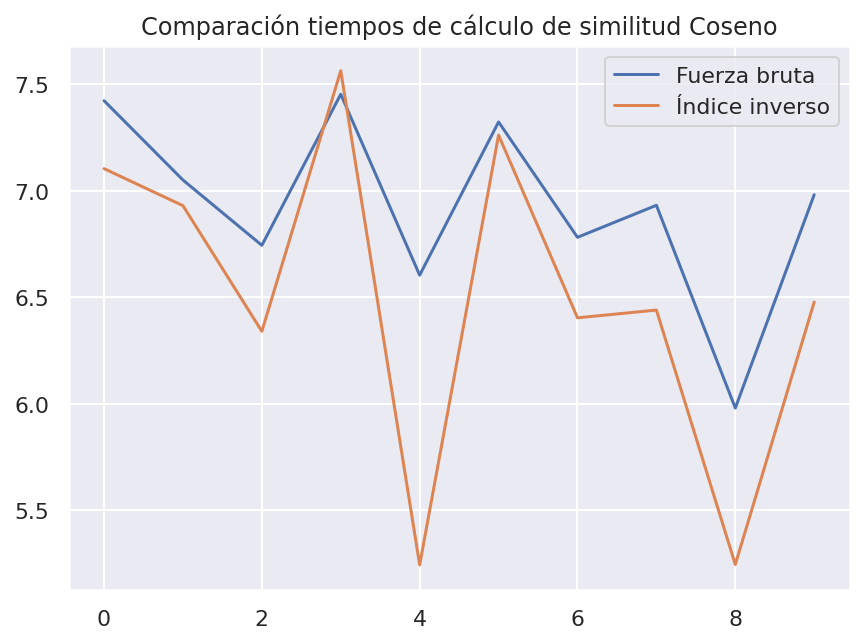

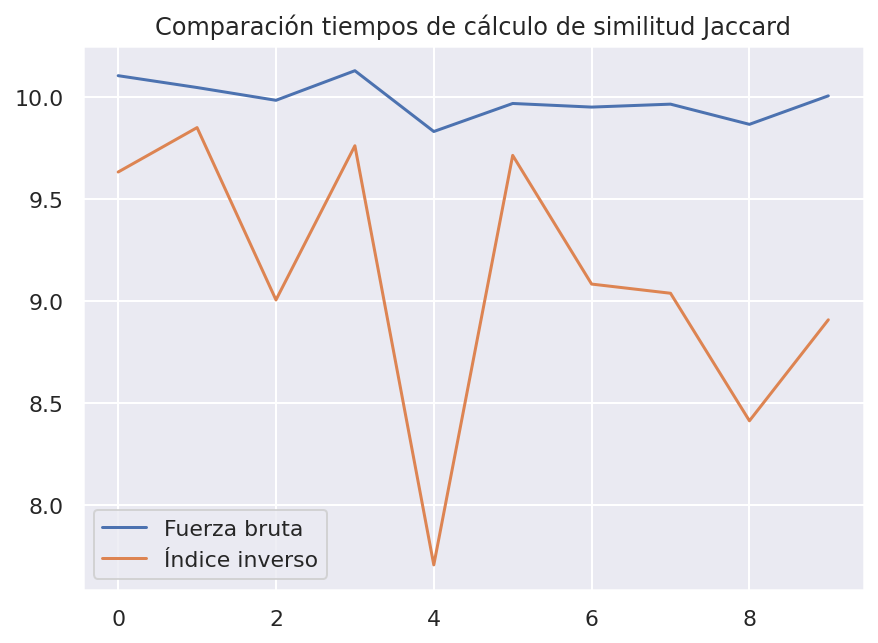

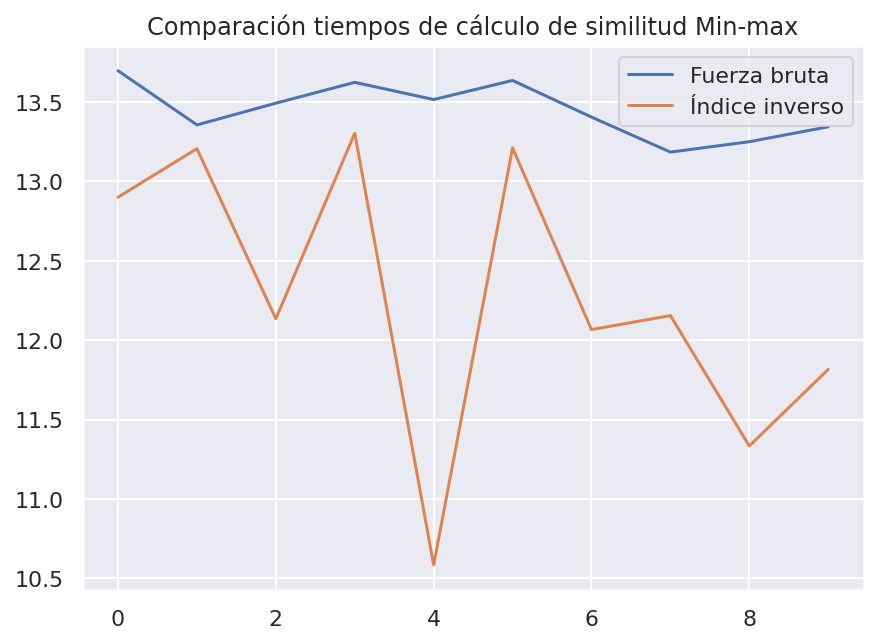

In [ ]:
import time as tm 

plt.rcParams["figure.figsize"] = (7,5)

# Crear las bolsas para las primeras 10 reseñas
dcs = [0,1,2,3,4,5,6,7,8,9]
bolsas_dc = []
for i in dcs:
  bolsas_dc.append(bolsas[i])

# Similitudes
similitudes = [similitud_coseno, similitud_jaccard, similitud_minmax]
nombres = ['Coseno', 'Jaccard', 'Min-max']

# DataFrame que guardará las similitudes máximas
barras = pd.DataFrame(columns = ['similitud', 'doc', 'cantidad'])

# Para cada tipo de similitud
for k, simi in enumerate(similitudes):

  tiempos_fb = []
  tiempos_ii = []

  # Para cada reseña (de las 10 a buscar)
  for j, x in enumerate(bolsas_dc):
    # Descarta de las bolsas la bolsa del documento a buscar
    bolsas_base = [b for i,b in enumerate(bolsas) if i != dcs[j]]
    # Toma el tiempo que se tarda buscar por fuerza bruta
    start = tm.time()
    sims = fuerza_bruta(bolsas_base, bolsas_dc[j], simi)
    end = tm.time()
    tiempos_fb.append(end-start)
    # Agrega la similitud obtenida al Data Frame
    barras.loc[len(barras.index)] = [nombres[k], 'Doc ' + str(j), np.nanmax(sims)] 
    # Toma el tiempo que se tarda con indice inverso
    start = tm.time()
    sims = indice_inverso(bolsas_base, bolsas_dc[j], simi)
    end = tm.time()
    tiempos_ii.append(end-start)

  # Grafica los tiempos
  plt.plot(tiempos_fb)
  plt.plot(tiempos_ii)
  plt.title('Comparación tiempos de cálculo de similitud ' + nombres[k])
  plt.legend(labels=['Fuerza bruta', 'Índice inverso'])
  plt.show()


Se puede ver que en general haciendo uso del ínidice inverso se tienen búsquedas más rápidas, aunque no hay una diferencia abismal. Lo anterior se puede deber a que la implementación del índice inverso no está optimizada en un envoltorio de C por ejemplo o tal vez porque la similitud con los documentos es no cero para la mayoría, probablemente en las reseñas la palabra "wine" aparece en la mayoría, ocasionando que haya coincidencias con casi todo el conjunto, para arreglar esto se podría agregar dicha palabra a las stopwords y ver si hay un cambio.

A continuación se muestra una gráfica de barras que indica la similitud máxima encontrada para las primeras 10 reseñas, con los tres tipos de similitud.

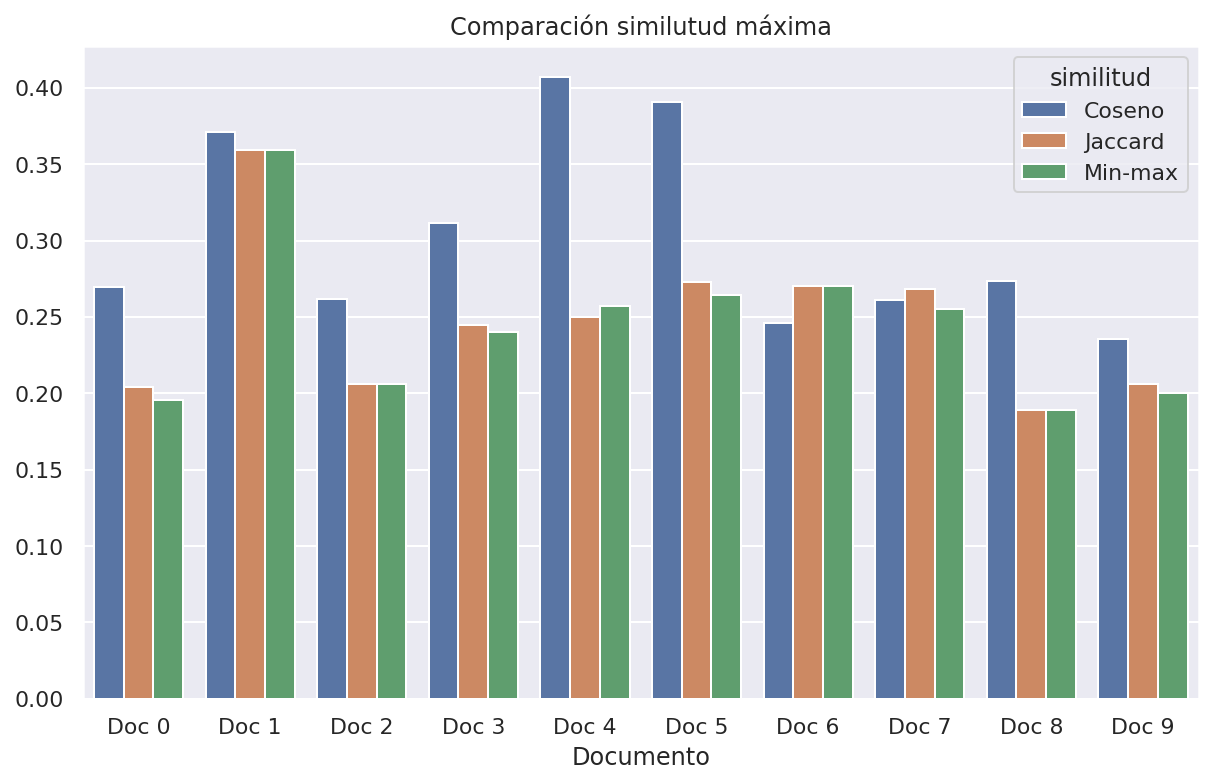

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="doc", hue="similitud", y="cantidad", data=barras)
plt.xlabel('Documento')
plt.ylabel('')
plt.title('Comparación similutud máxima')
plt.show()

Se puede observar que en la mayoría de los casos (a excepción de la reseña 6) se obtiene una similitud mayor con la Similitud Coseno. Además se obtiene esencialmente la misma similitud con Jaccard y con Min-max.

Finalmente se hará una comparación de tiempos, pero ahora entre las distintas similitudes, todas con el método que aprovecha el índice inverso.

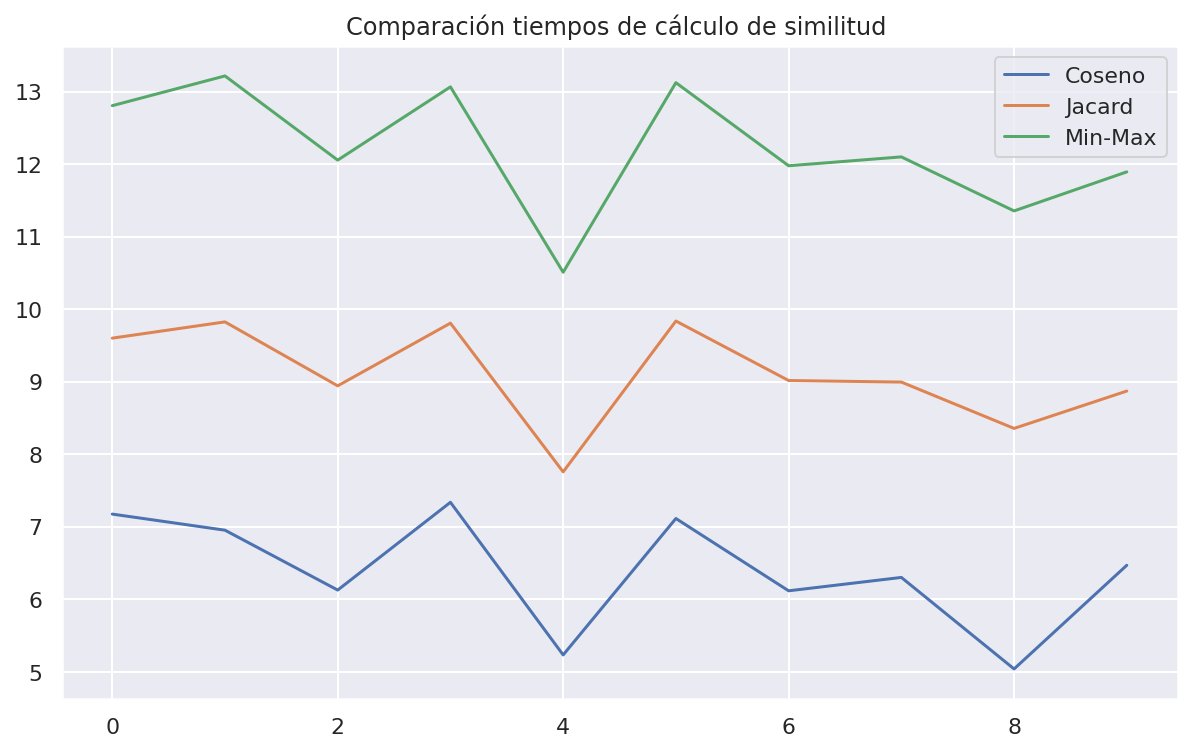

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
for k, simi in enumerate(similitudes):
  tiempos_ii = []

  for j, x in enumerate(bolsas_dc):
    start = tm.time()
    sims = indice_inverso(bolsas_base, bolsas_dc[j], simi)
    end = tm.time()
    tiempos_ii.append(end-start)

  plt.plot(tiempos_ii)
  plt.title('Comparación tiempos de cálculo de similitud ')
  plt.legend(labels=['Coseno', 'Jacard', 'Min-Max'])

plt.show()

Se puede observar que la similitud Coseno es la que menos se tarda, después le sigue la Jaccard y la más tardada es Min-max. Con lo anterior se puede decir que la mejor similitud es la Coseno porque es la menos tardada y además es con la que se obtienen mayores niveles de similitud. 

#Conclusiones

Con este método de búsqueda se puede generar un análisis sobre los sabores de los vinos de acuerdo a su procedencia, a la composición (tipo de uva), etc. de acuerdo a la opinión de expertos en el tema, y que estás opiniones sean tomadas en cuenta para lograr una optimización en la producción de vinos, es decir, saber con que tipo de uvas y de que regiones favorece un cierto sabor.
Además, lo más importante a destacar es la eficacia que posee este método del índice inverso sobre las medidas de similitud y como cada una de ellas lo afecta o favorece.